<a href="https://colab.research.google.com/github/nguyenvuong1309/Do-an-lap-trinh-an-toan/blob/main/BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import pandas as pd
from numpy import zeros, newaxis
import numpy as np
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional,Activation
import matplotlib.pyplot as plt
import csv


In [3]:
csv_file_path = '/content/drive/MyDrive/Colab/dataset/text_dataset.csv'
df = pd.read_csv(csv_file_path,sep=",")

In [4]:
dataset = df

In [5]:
print(dataset.head())

   Index                                                  1  label
0      0  1 150200/dirent_uri.c memset 405\nconst char *...      0
1      1  2 79848/CWE134_Uncontrolled_Format_String__cha...      0
2      2  3 94203/CWE319_Cleartext_Tx_Sensitive_Info__w3...      0
3      3  4 151133/utils.c strcmp 737\nint avformat_open...      0
4      4  5 94266/CWE319_Cleartext_Tx_Sensitive_Info__w3...     32


In [6]:
dataset = dataset[['1','label']]
dataset.head()

,1,label
0,1 150200/dirent_uri.c memset 405\nconst char *...,0
1,2 79848/CWE134_Uncontrolled_Format_String__cha...,0
2,3 94203/CWE319_Cleartext_Tx_Sensitive_Info__w3...,0
3,4 151133/utils.c strcmp 737\nint avformat_open...,0
4,5 94266/CWE319_Cleartext_Tx_Sensitive_Info__w3...,32


In [7]:
print(dataset['label'].unique())
print(len(dataset['label'].unique()))

[ 0 32  4 10 20 36  3  1 12 25 15 34 16 11  2 14 35 38  9 29  7 18 37 21
 22 23  5  8 17 31 39 33 28 30 19 40 26 13 24 27  6]
41


In [8]:
# train_dataset = dataset[0:int(len(dataset) * 0.8)]
# test_dataset =  dataset[int(len(dataset) * 0.8) :]
TRAIN_RATIO = 0.6
TEST_RATIO = 0.4


train_dataset = pd.DataFrame()
test_dataset = pd.DataFrame()
for i in range(41):
  temp_train = dataset[dataset['label'] == i][:int(TRAIN_RATIO * (dataset[dataset['label'] == i].shape[0]))]
  train_dataset = pd.concat([temp_train, train_dataset], axis=0, ignore_index=True)
  temp_test = dataset[dataset['label'] == i][int(TRAIN_RATIO * (dataset[dataset['label'] == i].shape[0])) : int((dataset[dataset['label'] == 0].shape[0]))]
  test_dataset = pd.concat([temp_test, test_dataset], axis=0, ignore_index=True)

print(train_dataset['label'].value_counts())
print(test_dataset['label'].value_counts())
train_dataset = train_dataset.sample(frac = 1)
test_dataset = test_dataset.sample(frac = 1)


0     82362
3     11031
20     3123
15     2386
4      2110
10     1133
2      1012
1       866
12      547
14      474
32      364
36      252
34      250
29      249
18      195
9       171
25      171
17      156
16      125
5       117
11      112
35      110
33      106
8        85
39       57
31       54
28       51
23       39
22       36
7        35
37       32
27       27
19       25
21       25
30       22
26       19
13       18
38       12
6         9
40        9
24        8
Name: label, dtype: int64
0     54909
3      7354
20     2083
15     1591
4      1408
10      756
2       676
1       578
12      365
14      316
32      244
36      168
34      168
29      166
18      130
25      115
9       114
17      104
16       84
5        78
11       76
35       74
33       72
8        57
39       39
31       36
28       35
23       26
22       25
7        24
37       22
21       18
27       18
19       17
30       15
26       14
13       12
38        9
6         7
40        7
24

In [9]:
#<_MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>
text_data = train_dataset['1'].values
tensor = tf.data.Dataset.from_tensor_slices(text_data)

In [10]:
tensor

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [11]:
train_dataset_numpy = np.array(train_dataset)

In [12]:
print(train_dataset_numpy[:3])

[["28905 71311/CWE122_Heap_Based_Buffer_Overflow__c_CWE805_char_memcpy_84_goodG2B.cpp free 41\nstatic void goodG2B() 38\nchar * data ; 40\ndata = NULL; 41\nCWE122_Heap_Based_Buffer_Overflow__c_CWE805_char_memcpy_84_goodG2B * goodG2BObject = new CWE122_Heap_Based_Buffer_Overflow__c_CWE805_char_memcpy_84_goodG2B ( data ) ; 42\nCWE122_Heap_Based_Buffer_Overflow__c_CWE805_char_memcpy_84_goodG2B::CWE122_Heap_Based_Buffer_Overflow__c_CWE805_char_memcpy_84_goodG2B(char * dataCopy) 23\ndata = dataCopy; 25\ndata = ( char * ) malloc ( 100 * sizeof ( char ) ); 27\ndata [ 0 ] = '\\0'; 28\ndelete goodG2BObject 43\nCWE122_Heap_Based_Buffer_Overflow__c_CWE805_char_memcpy_84_goodG2B::~CWE122_Heap_Based_Buffer_Overflow__c_CWE805_char_memcpy_84_goodG2B() 31\nchar source [ 100 ] ; 34\nmemset ( source , 'C' , 100 - 1 ); 35\nsource [ 100 - 1 ] = '\\0'; 36\nmemcpy ( data , source , 100 * sizeof ( char ) ); 38\ndata [ 100 - 1 ] = '\\0'; 39\nfree ( data ); 41\n0\n"
  0]
 ['44361 81694/CWE134_Uncontrolled_Form

In [13]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [14]:
train_dataset = train_dataset.sample(frac=1, replace=True, random_state=1)
test_dataset = test_dataset.sample(frac=1, replace=True, random_state=1)

In [15]:
print(train_dataset.shape)

(107985, 2)


In [16]:
len_dataset = int(train_dataset.shape[0])
x = np.array([i for i in range(41)])
y = np.array([])
for i in range(41):
  number = int(train_dataset[train_dataset['label'] == i].shape[0])
  y = np.insert(y,len(y),number)


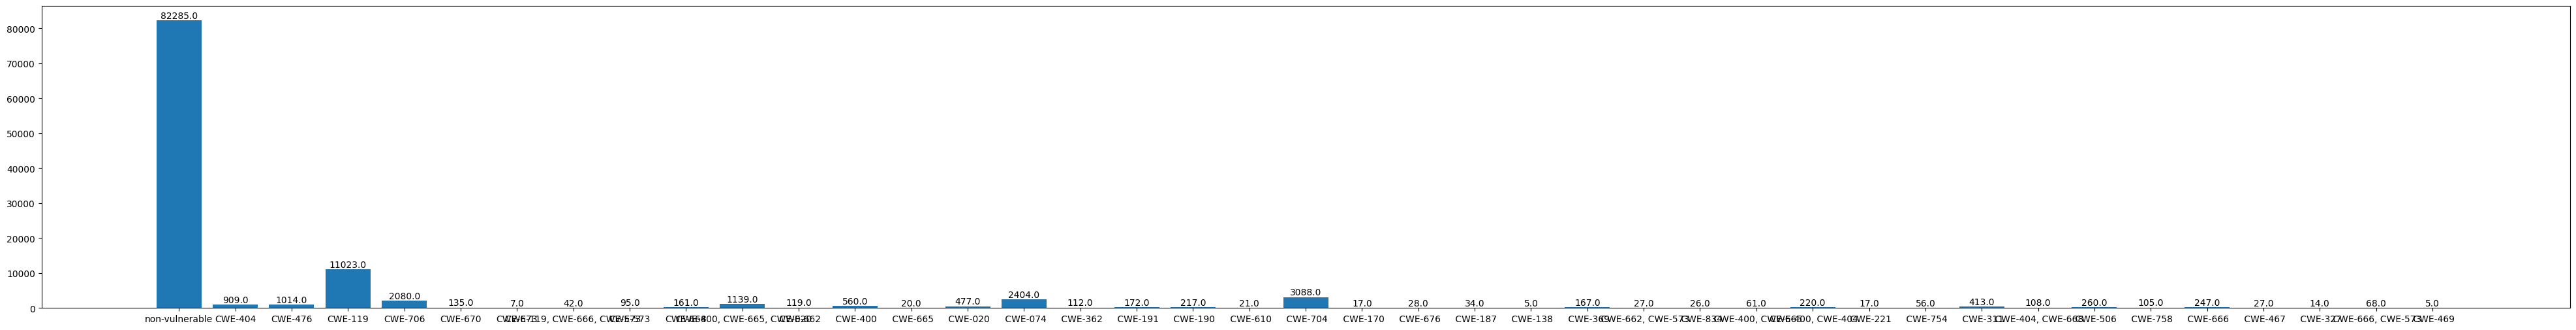

In [17]:
x_cwe = ["non-vulnerable","CWE-404","CWE-476","CWE-119","CWE-706","CWE-670","CWE-673","CWE-119, CWE-666, CWE-573","CWE-573","CWE-668"," CWE-400, CWE-665, CWE-020",
         " CWE-662"," CWE-400"," CWE-665"," CWE-020", " CWE-074"," CWE-362"," CWE-191"," CWE-190"," CWE-610"," CWE-704"," CWE-170"," CWE-676"," CWE-187"," CWE-138",
         " CWE-369"," CWE-662, CWE-573"," CWE-834"," CWE-400, CWE-665"," CWE-400, CWE-404"," CWE-221", " CWE-754"," CWE-311"," CWE-404, CWE-668"," CWE-506"," CWE-758",
         " CWE-666"," CWE-467"," CWE-327"," CWE-666, CWE-573"," CWE-469"]

fig, ax = plt.subplots(figsize=(50, 6))

# Plot the bar chart
bars = ax.bar(x_cwe, y, label='Some label')

# Add annotations for each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'{height}', ha='center', va='bottom')

# Show the plot
plt.show()

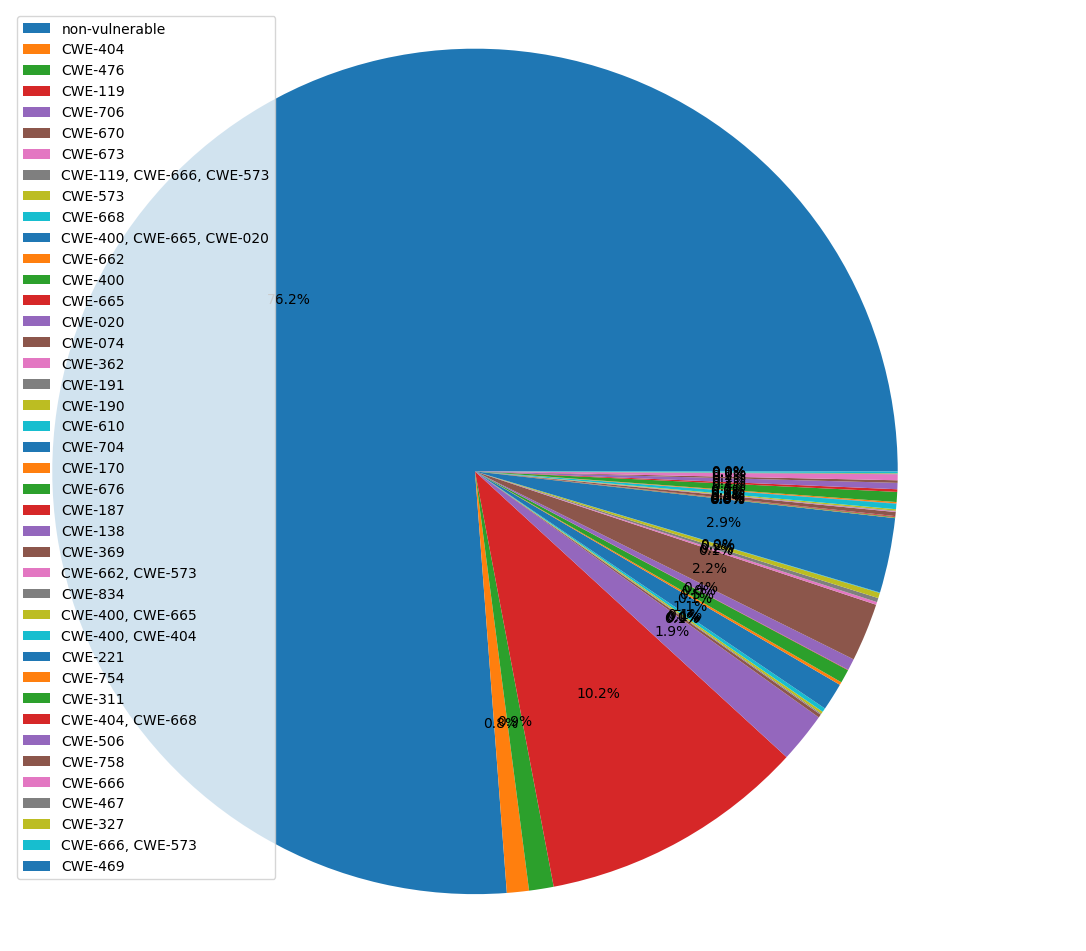

In [18]:
import matplotlib.pyplot as plt
from collections import Counter

# Sample data
x_cwe = ["non-vulnerable", "CWE-404", "CWE-476", "CWE-119", "CWE-706", "CWE-670", "CWE-673", "CWE-119, CWE-666, CWE-573",
         "CWE-573", "CWE-668", "CWE-400, CWE-665, CWE-020", "CWE-662", "CWE-400", "CWE-665", "CWE-020", "CWE-074", "CWE-362",
         "CWE-191", "CWE-190", "CWE-610", "CWE-704", "CWE-170", "CWE-676", "CWE-187", "CWE-138", "CWE-369", "CWE-662, CWE-573",
         "CWE-834", "CWE-400, CWE-665", "CWE-400, CWE-404", "CWE-221", "CWE-754", "CWE-311", "CWE-404, CWE-668", "CWE-506",
         "CWE-758", "CWE-666", "CWE-467", "CWE-327", "CWE-666, CWE-573", "CWE-469"]
# Count occurrences of each CWE
cwe_counter = Counter(x_cwe)
cwe_values = list(cwe_counter.values())

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the pie chart
wedges, texts, autotexts = ax.pie(y, labels=cwe_counter.keys(), autopct='%1.1f%%', textprops=dict(color="w"))

# Add percentage annotations
for autotext in autotexts:
    autotext.set_color('black')

# Set the aspect ratio to be equal, ensuring the pie is drawn as a circle
ax.axis('equal')
plt.legend()

# Show the plot
plt.show()


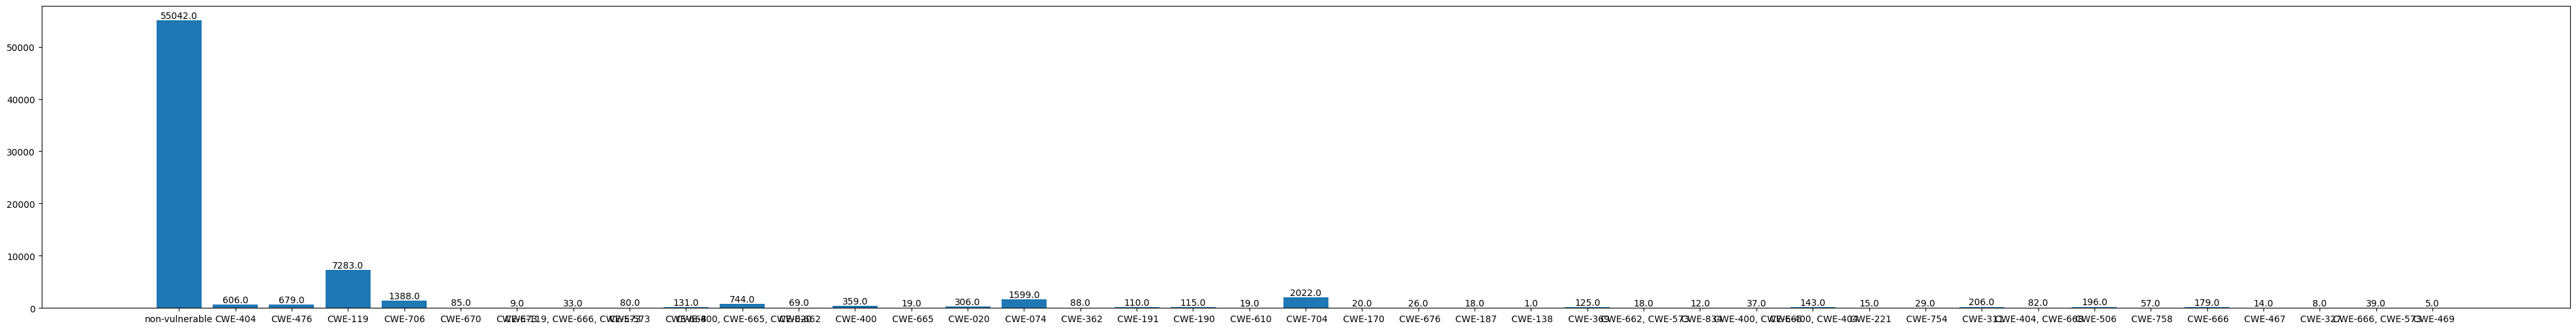

In [19]:
len_test_dataset = int(test_dataset.shape[0])
y_test_dataset = np.array([])
for i in range(41):
  number = int(test_dataset[test_dataset['label'] == i].shape[0])
  y_test_dataset = np.insert(y_test_dataset,len(y_test_dataset),number)

x_cwe = ["non-vulnerable","CWE-404","CWE-476","CWE-119","CWE-706","CWE-670","CWE-673","CWE-119, CWE-666, CWE-573","CWE-573","CWE-668"," CWE-400, CWE-665, CWE-020",
         " CWE-662"," CWE-400"," CWE-665"," CWE-020", " CWE-074"," CWE-362"," CWE-191"," CWE-190"," CWE-610"," CWE-704"," CWE-170"," CWE-676"," CWE-187"," CWE-138",
         " CWE-369"," CWE-662, CWE-573"," CWE-834"," CWE-400, CWE-665"," CWE-400, CWE-404"," CWE-221", " CWE-754"," CWE-311"," CWE-404, CWE-668"," CWE-506"," CWE-758",
         " CWE-666"," CWE-467"," CWE-327"," CWE-666, CWE-573"," CWE-469"]

fig, ax = plt.subplots(figsize=(50, 6))
# Plot the bar chart
bars = ax.bar(x_cwe, y_test_dataset, label='Some label')

# Add annotations for each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'{height}', ha='center', va='bottom')

# Show the plot
plt.show()

# Data augmentation

In [20]:
pip install nlpaug

In [21]:
import nlpaug.augmenter.char as nac

test_sentence = 'I went Shopping Today, and my trolly was filled with Bananas. I also had food at burgur palace'

aug = nac.KeyboardAug(name='Keyboard_Aug', aug_char_min=1, aug_char_max=10, aug_char_p=0.3, aug_word_p=0.3,
                      aug_word_min=1, aug_word_max=10, stopwords=None, tokenizer=None, reverse_tokenizer=None,
                      include_special_char=True, include_numeric=True, include_upper_case=True, lang='en', verbose=0,
                      stopwords_regex=None, model_path=None, min_char=4)

test_sentence_aug = aug.augment(test_sentence)

In [ ]:
for i in range(1,41):


In [22]:
print(test_sentence_aug)

['I dejt Shopping ToVa&, and my trolly was f9;led w8tU Bananas. I also had bo)d at burgur 0xlace']


# Model preparation

In [23]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(tensor)

In [24]:
train_dataset['1']

45199    25750 90762/CWE23_Relative_Path_Traversal__cha...
3369     50592 88116/CWE195_Signed_to_Unsigned_Conversi...
84201    76909 85624/CWE191_Integer_Underflow__int_list...
91225    86163 79249/CWE134_Uncontrolled_Format_String_...
13856    11332 76222/CWE126_Buffer_Overread__CWE170_wch...
                               ...                        
25710    105 150237/gimpimage.c malloc 298\nvoid *stone...
53075    36017 94148/CWE319_Cleartext_Tx_Sensitive_Info...
60206    45301 120792/CWE78_OS_Command_Injection__wchar...
66142    53122 117450/CWE789_Uncontrolled_Mem_Alloc__ma...
73178    62427 118144/CWE78_OS_Command_Injection__char_...
Name: 1, Length: 107985, dtype: object

In [25]:
train_dataset

,1,label
45199,25750 90762/CWE23_Relative_Path_Traversal__cha...,0
3369,50592 88116/CWE195_Signed_to_Unsigned_Conversi...,20
84201,76909 85624/CWE191_Integer_Underflow__int_list...,0
91225,86163 79249/CWE134_Uncontrolled_Format_String_...,0
13856,11332 76222/CWE126_Buffer_Overread__CWE170_wch...,3
...,...,...
25710,105 150237/gimpimage.c malloc 298\nvoid *stone...,0
53075,36017 94148/CWE319_Cleartext_Tx_Sensitive_Info...,0
60206,45301 120792/CWE78_OS_Command_Injection__wchar...,0
66142,53122 117450/CWE789_Uncontrolled_Mem_Alloc__ma...,0


In [26]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', '0', 'if', 'data', '1', 'char', 'void', 'i', 'd',
       'service', 's', 'sizeof', 'int', '100', 'recvresult', '2',
       'static', 'datalen', 'null'], dtype='<U559')

In [27]:
# example = [[' /CWE_Heap_Based_Buffer_Overflow__cpp_CWE_char_snprintf_.cpp memset \nvoid bad() \nchar * data ; \ndata = new char [  ]; \nif ( GLOBAL_CONST_TRUE )  \nmemset ( data , \'A\' ,  -  ); \ndata [  -  ] = \'\\\'; \nSNPRINTF ( dest , strlen ( data ) , "%s" , data ); \nprintLine ( data ); \nvoid printLine (const char * line) \nif ( line != NULL )  \nprintf ( "%s\\n" , line ); \ndelete [ ] data \n\n'],
#  [' /CWE_Trapdoor__ip_based_logic_.c send \nvoid CWE_Trapdoor__ip_based_logic__bad() \nWSADATA wsaData ; \nstruct sockaddr_in service , acceptService ; \nif ( WSAStartup ( MAKEWORD (  ,  ) , & wsaData ) != NO_ERROR )  \nlistenSocket = socket ( AF_INET , SOCK_STREAM , IPPROTO_TCP ); \nif ( listenSocket == INVALID_SOCKET )  \nmemset ( & service ,  , sizeof ( service ) ); \nservice . sin_family = AF_INET; \nservice . sin_addr . s_addr = INADDR_ANY; \nservice . sin_port = htons (  ); \nif ( bind ( listenSocket , ( struct sockaddr * ) & service , sizeof ( service ) ) == SOCKET_ERROR )  \nif ( listen ( listenSocket ,  ) == SOCKET_ERROR )  \nacceptSocket = accept ( listenSocket , NULL , NULL ); \nif ( acceptSocket == SOCKET_ERROR )  \nif ( getsockname ( acceptSocket , ( struct sockaddr * ) & acceptService , & acceptServiceLen ) == -  )  \nif ( strcmp ( "..." , inet_ntoa ( acceptService . sin_addr ) ) ==  )  \nif ( send ( acceptSocket , ADMIN_MESSAGE , strlen ( ADMIN_MESSAGE ) ,  ) == SOCKET_ERROR )  \nif ( send ( acceptSocket , DEFAULT_MESSAGE , strlen ( DEFAULT_MESSAGE ) ,  ) == SOCKET_ERROR )  \nwhile (  )  \n\n'],
#  [' /CWE_OS_Command_Injection__char_console_wspawnl_.c strlen \nvoid CWE_OS_Command_Injection__char_console_wspawnl__bad() \nchar * data ; \nchar dataBuffer [  ] = "" ; \ndata = dataBuffer; \nif ( staticFive ==  )  \nsize_t dataLen = strlen ( data ) ; \nif (  - dataLen >  )  \nif ( fgets ( data + dataLen , ( int ) (  - dataLen ) , stdin ) != NULL )  \ndataLen = strlen ( data ); \nif ( dataLen >  && data [ dataLen -  ] == \'\\n\' )  \ndata [ dataLen -  ] = \'\\\'; \n\n']
#            ]

In [28]:
# encoded_example = encoder(example)[:3].numpy()
# encoded_example

In [29]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(41, activation='softmax')
])

In [30]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [31]:
X_train = train_dataset['1']
y_train = train_dataset['label']
y_train = tf.keras.utils.to_categorical(y_train, num_classes=41)

In [32]:
print(X_train.shape)
print(y_train.shape)

(107985,)
(107985, 41)


In [33]:
history = model.fit(X_train,y_train, epochs=1,
                    # validation_data=test_dataset,
                    # validation_steps=30
                    )

3375/3375 [==============================] - 446s 128ms/step - loss: 0.5123 - accuracy: 0.8910


In [34]:
X_test = test_dataset['1']
y_test = test_dataset['label']
y_test = tf.keras.utils.to_categorical(y_test, num_classes=41)

In [35]:
test_loss, test_acc = model.evaluate(X_test,y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

2251/2251 [==============================] - 75s 32ms/step - loss: 0.1576 - accuracy: 0.9590
Test Loss: 0.1576467603445053
Test Accuracy: 0.9590091109275818


In [36]:
y_pred = model.predict(X_test)
print(y_pred.shape)
print(y_pred)
print(y_test.shape)
print(y_test)

2251/2251 [==============================] - 72s 31ms/step
(72016, 41)
[[9.9985445e-01 1.7700479e-05 3.3577595e-05 ... 3.7219977e-10
  3.2130870e-07 2.5356959e-09]
 [9.9904162e-01 2.8793490e-04 1.2119511e-04 ... 1.9647919e-09
  1.0481604e-06 3.0593312e-09]
 [9.9986315e-01 1.4863933e-05 2.9187444e-05 ... 3.0325009e-10
  2.8306144e-07 2.1792732e-09]
 ...
 [9.9871254e-01 1.6493062e-04 5.3816306e-04 ... 1.0306408e-08
  2.6256118e-06 3.9114106e-08]
 [9.9969721e-01 4.5409171e-05 9.9119301e-05 ... 2.3221083e-09
  8.0300640e-07 1.2029793e-08]
 [9.9926919e-01 2.3504927e-04 1.1383792e-04 ... 2.0180040e-09
  1.0078654e-06 3.5839143e-09]]
(72016, 41)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [37]:
max_y_test_indices = np.argmax(y_test, axis=1)
max_y_pred_indices = np.argmax(y_pred, axis=1)

array_sum     = [0] * 41
array_correct = [0] * 41

array_sum = np.array(array_sum)
array_correct = np.array(array_correct)



for i in range(len(max_y_test_indices)):
  if max_y_test_indices[i] == max_y_pred_indices[i]:
    array_correct[max_y_test_indices[i]] += 1
  array_sum[max_y_test_indices[i]] += 1

print(array_sum)
print(len(array_sum))
print(array_correct)
print(len(array_correct))


[55042   606   679  7283  1388    85     9    33    80   131   744    69
   359    19   306  1599    88   110   115    19  2022    20    26    18
     1   125    18    12    37   143    15    29   206    82   196    57
   179    14     8    39     5]
41
[55042    27   585  7245  1380     0     0     0     0     0   710     0
   187     0   146  1596     0     0     0     0  1999     0     0     0
     0     0     0     0     0     0     0     0   147     0     0     0
     0     0     0     0     0]
41


[1.0, 0.04455445544554455, 0.8615611192930781, 0.9947823699025127, 0.9942363112391931, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9543010752688172, 0.0, 0.520891364902507, 0.0, 0.477124183006536, 0.99812382739212, 0.0, 0.0, 0.0, 0.0, 0.9886251236399605, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7135922330097088, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


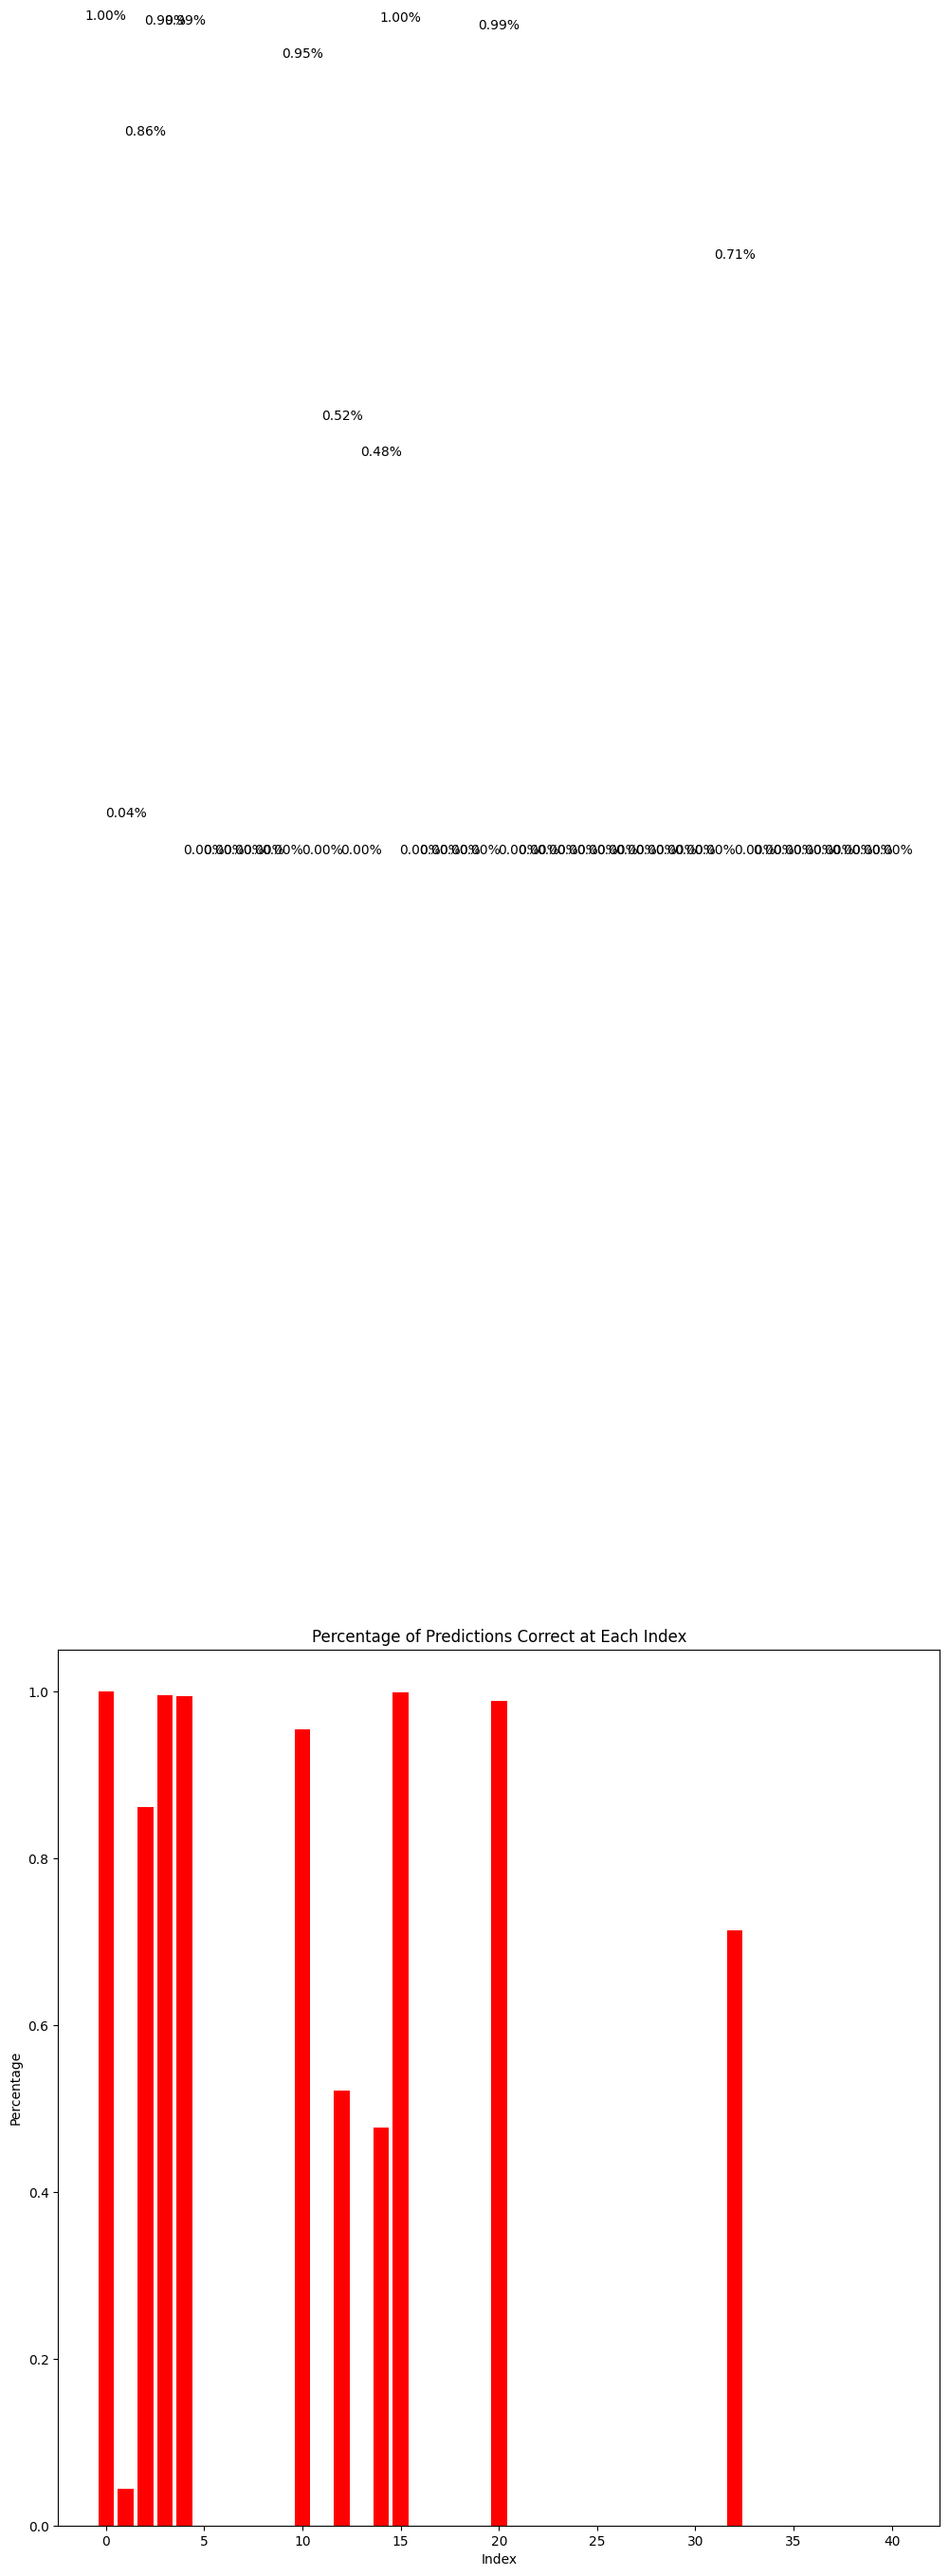

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
labels = array_sum
predictions = array_correct

# Calculate the percentage of correct predictions for each index
percentages = []
for i in range(len(labels)):
    percentage = predictions[i] * 1.0 / labels[i]
    percentages.append(percentage)

print(percentages)

# Create a bar chart for each index
fig, ax = plt.subplots(figsize=(12, 12))
# fig, ax = plt.subplots()
ax.bar(range(len(labels)), percentages, color=['green' if p == 100 else 'red' for p in percentages])
ax.set_xlabel('Index')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Predictions Correct at Each Index')

# Display the percentage on top of the bars
for i, v in enumerate(percentages):
    ax.text(i, v + 2, f'{v:.2f}%', ha='center', va='bottom', color='black')
plt.show()
